# Sequential retrieval [GRU4Rec]

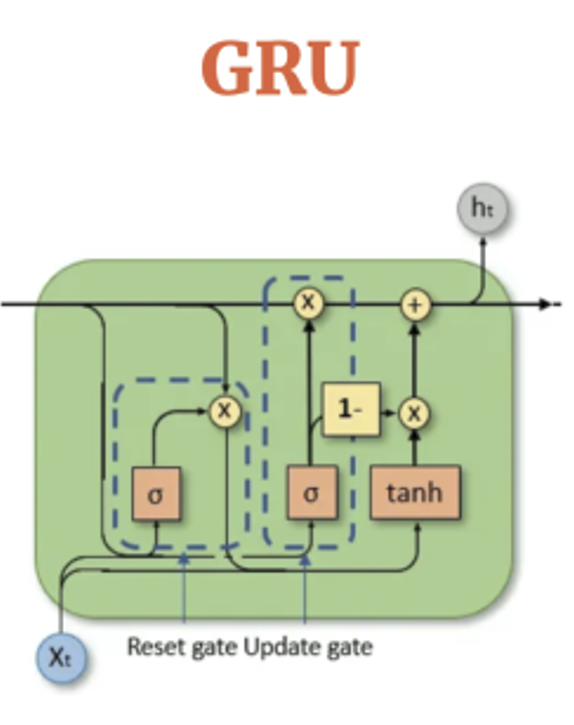

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from typing import List
from tqdm import tqdm

## Введение

В этом примере мы построим модель последовательного поиска. Последовательные рекомендации — это популярная модель, которая анализирует последовательность элементов, с которыми пользователи ранее взаимодействовали, а затем прогнозирует следующий элемент. Здесь важен порядок элементов в каждой последовательности. Поэтому мы будем использовать рекуррентную нейронную сеть для моделирования последовательной взаимосвязи. Подробнее см. в статье [GRU4Rec](https://arxiv.org/abs/1511.06939).

Начнём с выбора JAX в качестве бэкенда, на котором мы хотим работать, и импортируем все необходимые библиотеки.

In [2]:
!pip install -q keras-rs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 3.4 MB/s eta 0:00:00


In [3]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # `"tensorflow"`/`"torch"`

import collections
import os
import random

import keras
import pandas as pd
import tensorflow as tf  # Needed only for the dataset

import keras_rs

Давайте также определим все важные переменные/гиперпараметры/

In [4]:
DATA_DIR = "./raw/data/"

# MovieLens-specific variables
MOVIELENS_1M_URL = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
MOVIELENS_ZIP_HASH = "a6898adb50b9ca05aa231689da44c217cb524e7ebd39d264c56e2832f2c54e20"

RATINGS_FILE_NAME = "ratings.dat"
MOVIES_FILE_NAME = "movies.dat"

# Data processing args
MAX_CONTEXT_LENGTH = 10
MIN_SEQUENCE_LENGTH = 3

RATINGS_DATA_COLUMNS = ["UserID", "MovieID", "Rating", "Timestamp"]
MOVIES_DATA_COLUMNS = ["MovieID", "Title", "Genres"]
MIN_RATING = 2

# Training/model args
BATCH_SIZE = 4096
TEST_BATCH_SIZE = 2048
EMBEDDING_DIM = 32
NUM_EPOCHS = 5
LEARNING_RATE = 0.005

## Набор данных

Далее нам нужно подготовить наш набор данных. Будем использовать набор данных MovieLens.

Подготовка набора данных довольно сложная. Исходный набор данных с рейтингами содержит кортежи `(user, movie ID, rating, timestamp)` (помимо других столбцов, которые не важны для данного примера). Поскольку мы имеем дело с последовательным поиском, нам нужно создать последовательности фильмов для каждого пользователя, упорядоченные по временной метке.

Начнём с загрузки и чтения набора данных.

In [5]:
# Download the MovieLens dataset.
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

path_to_zip = keras.utils.get_file(
    fname="ml-1m.zip",
    origin=MOVIELENS_1M_URL,
    file_hash=MOVIELENS_ZIP_HASH,
    hash_algorithm="sha256",
    extract=True,
    cache_dir=DATA_DIR,
)
movielens_extracted_dir = os.path.join(
    os.path.dirname(path_to_zip),
    "ml-1m_extracted",
    "ml-1m",
)


# Read the dataset.
def read_data(data_directory, min_rating=None):
    """Read movielens ratings.dat and movies.dat file
    into dataframe.
    """

    ratings_df = pd.read_csv(
        os.path.join(data_directory, RATINGS_FILE_NAME),
        sep="::",
        names=RATINGS_DATA_COLUMNS,
        encoding="unicode_escape",
        engine="python",
    )
    ratings_df["Timestamp"] = ratings_df["Timestamp"].apply(int)

    # Remove movies with `rating < min_rating`.
    if min_rating is not None:
        ratings_df = ratings_df[ratings_df["Rating"] >= min_rating]

    movies_df = pd.read_csv(
        os.path.join(data_directory, MOVIES_FILE_NAME),
        sep="::",
        names=MOVIES_DATA_COLUMNS,
        encoding="unicode_escape",
        engine="python",
    )
    return ratings_df, movies_df


ratings_df, movies_df = read_data(
    data_directory=movielens_extracted_dir, min_rating=MIN_RATING
)

# Need to know #movies so as to define embedding layers.
movies_count = movies_df["MovieID"].max()

5917549/5917549 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Теперь, когда мы прочитали набор данных, давайте создадим последовательности фильмов для каждого пользователя.

In [6]:

def get_movie_sequence_per_user(ratings_df):
    """Get movieID sequences for every user."""
    sequences = collections.defaultdict(list)

    for user_id, movie_id, rating, timestamp in ratings_df.values:
        sequences[user_id].append(
            {
                "movie_id": movie_id,
                "timestamp": timestamp,
                "rating": rating,
            }
        )

    # Sort movie sequences by timestamp for every user.
    for user_id, context in sequences.items():
        context.sort(key=lambda x: x["timestamp"])
        sequences[user_id] = context

    return sequences


Прежде чем приступить к обучению модели, необходимо выполнить фильтрацию и обработку:

1. Сформировать последовательности всех длин вплоть до
`min(user_sequence_length, MAX_CONTEXT_LENGTH)`. Таким образом, каждому пользователю
будет соответствовать несколько последовательностей.
2. Получить метки, т.е. если задана последовательность длиной `n`, первые
`n-1` токены будут поданы в модель в качестве входных данных, а метка
будет последним токеном.
3. Удалить все пользовательские последовательности с длиной фильмов меньше `MIN_SEQUENCE_LENGTH`.

4. Дополнить все последовательности до `MAX_CONTEXT_LENGTH`.

Важный момент, который следует отметить, — это то, как мы формируем разделение на обучающую и тестовую части. Мы не
формируем весь набор данных последовательностей, а затем разделяем его на обучающую и тестовую части. Вместо этого для каждого пользователя мы включаем последнюю последовательность в тестовый набор,
а все остальные последовательности — в обучающий. Это сделано для предотвращения утечки данных.

In [7]:

def generate_examples_from_user_sequences(sequences):
    """Generates sequences for all users, with padding, truncation, etc."""

    def generate_examples_from_user_sequence(sequence):
        """Generates examples for a single user sequence."""

        train_examples = []
        test_examples = []
        for label_idx in range(1, len(sequence)):
            start_idx = max(0, label_idx - MAX_CONTEXT_LENGTH)
            context = sequence[start_idx:label_idx]

            # Padding
            while len(context) < MAX_CONTEXT_LENGTH:
                context.append(
                    {
                        "movie_id": 0,
                        "timestamp": 0,
                        "rating": 0.0,
                    }
                )

            label_movie_id = int(sequence[label_idx]["movie_id"])
            context_movie_id = [int(movie["movie_id"]) for movie in context]

            example = {
                "context_movie_id": context_movie_id,
                "label_movie_id": label_movie_id,
            }

            if label_idx == len(sequence) - 1:
                test_examples.append(example)
            else:
                train_examples.append(example)

        return train_examples, test_examples

    all_train_examples = []
    all_test_examples = []
    for sequence in sequences.values():
        if len(sequence) < MIN_SEQUENCE_LENGTH:
            continue

        user_train_examples, user_test_example = generate_examples_from_user_sequence(
            sequence
        )

        all_train_examples.extend(user_train_examples)
        all_test_examples.extend(user_test_example)

    return all_train_examples, all_test_examples


In [8]:
# test_examples

Давайте разделим набор данных на обучающий и тестовый. Также нам нужно изменить формат словаря набора данных, чтобы обеспечить преобразование в объект `tf.data.Dataset`.

In [9]:
sequences = get_movie_sequence_per_user(ratings_df)
train_examples, test_examples = generate_examples_from_user_sequences(sequences)


def list_of_dicts_to_dict_of_lists(list_of_dicts):
    """Convert list of dictionaries to dictionary of lists for
    `tf.data` conversion.
    """
    dict_of_lists = collections.defaultdict(list)
    for dictionary in list_of_dicts:
        for key, value in dictionary.items():
            dict_of_lists[key].append(value)
    return dict_of_lists


train_examples = list_of_dicts_to_dict_of_lists(train_examples)
test_examples = list_of_dicts_to_dict_of_lists(test_examples)

train_ds = tf.data.Dataset.from_tensor_slices(train_examples).map(
    lambda x: (x["context_movie_id"], x["label_movie_id"])
)
test_ds = tf.data.Dataset.from_tensor_slices(test_examples).map(
    lambda x: (x["context_movie_id"], x["label_movie_id"])
)

Нам нужно пакетировать наши наборы данных. Мы также используем `cache()` и `prefetch()` для повышения производительности.

In [10]:
train_ds = train_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(TEST_BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

Let's print out one batch.

In [11]:
for sample in train_ds.take(1):
    print(sample)

(<tf.Tensor: shape=(4096, 10), dtype=int32, numpy=
array([[3186,    0,    0, ...,    0,    0,    0],
       [3186, 1270,    0, ...,    0,    0,    0],
       [3186, 1270, 1721, ...,    0,    0,    0],
       ...,
       [2194, 1291, 2159, ...,  300, 2076,  866],
       [1291, 2159, 1012, ..., 2076,  866, 2206],
       [2159, 1012, 1092, ...,  866, 2206,  377]], dtype=int32)>, <tf.Tensor: shape=(4096,), dtype=int32, numpy=array([1270, 1721, 1022, ..., 2206,  377, 1357], dtype=int32)>)


## Модель и обучение

В простом примере поиска мы использовали одну башню запросов для пользователя и башню-кандидат для фильма-кандидата. Здесь мы также будем использовать архитектуру с двумя башнями. Однако мы используем башню запросов со слоем Gated Recurrent Unit (GRU) для кодирования последовательности исторических фильмов и используем ту же башню-кандидат для фильма-кандидата.

Примечание: Обратите внимание на определение меток. Тензор меток (имеющий вид `(batch_size, batch_size)`) содержит унитарные векторы. Идея заключается в следующем: для каждого образца рассматривать идентификаторы фильмов, соответствующие другим образцам в пакете, как отрицательные.

In [12]:

class SequentialRetrievalModel(keras.Model):
    """Create the sequential retrieval model.

    Args:
      movies_count: Total number of unique movies in the dataset.
      embedding_dimension: Output dimension for movie embedding tables.
    """

    def __init__(
        self,
        movies_count,
        embedding_dimension=128,
        **kwargs,
    ):
        super().__init__(**kwargs)
        # Our query tower, simply an embedding table followed by
        # a GRU unit. This encodes sequence of historical movies.
        self.query_model = keras.Sequential(
            [
                keras.layers.Embedding(movies_count + 1, embedding_dimension),
                keras.layers.GRU(embedding_dimension),
            ]
        )

        # Our candidate tower, simply an embedding table.
        self.candidate_model = keras.layers.Embedding(
            movies_count + 1, embedding_dimension
        )

        # The layer that performs the retrieval.
        self.retrieval = keras_rs.layers.BruteForceRetrieval(k=10, return_scores=False)
        self.loss_fn = keras.losses.CategoricalCrossentropy(
            from_logits=True,
        )

    def build(self, input_shape):
        self.query_model.build(input_shape)
        self.candidate_model.build(input_shape)

        # In this case, the candidates are directly the movie embeddings.
        # We take a shortcut and directly reuse the variable.
        self.retrieval.candidate_embeddings = self.candidate_model.embeddings
        self.retrieval.build(input_shape)
        super().build(input_shape)

    def call(self, inputs, training=False):
        query_embeddings = self.query_model(inputs)
        result = {
            "query_embeddings": query_embeddings,
        }

        if not training:
            # Skip the retrieval of top movies during training as the
            # predictions are not used.
            result["predictions"] = self.retrieval(query_embeddings)
        return result

    def compute_loss(self, x, y, y_pred, sample_weight, training=True):
        candidate_id = y
        query_embeddings = y_pred["query_embeddings"]
        candidate_embeddings = self.candidate_model(candidate_id)

        num_queries = keras.ops.shape(query_embeddings)[0]
        num_candidates = keras.ops.shape(candidate_embeddings)[0]

        # One-hot vectors for labels.
        labels = keras.ops.eye(num_queries, num_candidates)

        # Compute the affinity score by multiplying the two embeddings.
        scores = keras.ops.matmul(
            query_embeddings, keras.ops.transpose(candidate_embeddings)
        )

        return self.loss_fn(labels, scores, sample_weight)


Давайте создадим, скомпилируем и обучим нашу модель.

In [13]:
model = SequentialRetrievalModel(
    movies_count=movies_count, embedding_dimension=EMBEDDING_DIM
)

# Compile.
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=LEARNING_RATE))

# Train.
model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=NUM_EPOCHS,
)

Epoch 1/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 7.9447 - val_loss: 6.7962
Epoch 2/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7.0543 - val_loss: 6.5359
Epoch 3/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.8149 - val_loss: 6.4241
Epoch 4/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6960 - val_loss: 6.3693
Epoch 5/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6236 - val_loss: 6.3375


## Прогнозирование

Теперь, когда у нас есть модель, мы хотели бы иметь возможность делать прогнозы.

До сих пор мы обрабатывали фильмы только по идентификаторам. Теперь пришло время создать сопоставление, связанное с идентификаторами фильмов, чтобы иметь возможность отображать названия.

In [14]:
movie_id_to_movie_title = dict(zip(movies_df["MovieID"], movies_df["Title"]))
movie_id_to_movie_title[0] = ""  # Because id 0 is not in the dataset.

Затем мы просто используем метод Keras `model.predict()`. На самом деле, он вызывает слой `BruteForceRetrieval` для выполнения фактического поиска.

Обратите внимание, что эта модель может извлекать фильмы, которые уже смотрел пользователь. Мы могли бы легко добавить логику для их удаления, если это необходимо.

In [15]:
print("\n==> Movies the user has watched:")
movie_sequence = test_ds.unbatch().take(1)
for element in movie_sequence:
    for movie_id in element[0][:-1]:
        print(movie_id_to_movie_title[movie_id.numpy()], end=", ")
    print(movie_id_to_movie_title[element[0][-1].numpy()])

predictions = model.predict(movie_sequence.batch(1))
predictions = keras.ops.convert_to_numpy(predictions["predictions"])

print("\n==> Recommended movies for the above sequence:")
for movie_id in predictions[0]:
    print(movie_id_to_movie_title[movie_id])


==> Movies the user has watched:
Beauty and the Beast (1991), Tarzan (1999), Close Shave, A (1995), Aladdin (1992), Toy Story (1995), Bug's Life, A (1998), Antz (1998), Hunchback of Notre Dame, The (1996), Hercules (1997), Mulan (1998)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step

==> Recommended movies for the above sequence:
Prince of Egypt, The (1998)
Hunchback of Notre Dame, The (1996)
James and the Giant Peach (1996)
Anastasia (1997)
Return of Jafar, The (1993)
Pocahontas (1995)
Mulan (1998)
Hercules (1997)
Lion King, The (1994)
Rescuers Down Under, The (1990)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


# **Часть С Лабораторной**

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
df_users = pd.read_csv('/content/drive/MyDrive/2025Mag2/RecSys/DataSet/users.csv')
df_items = pd.read_csv('/content/drive/MyDrive/2025Mag2/RecSys/DataSet/items.csv')
df_interactions = pd.read_csv('/content/drive/MyDrive/2025Mag2/RecSys/DataSet/interactions.csv')

In [18]:
# df_users = pd.read_csv('/content/users.csv')
# df_items = pd.read_csv('/content/items.csv')
# df_interactions = pd.read_csv("/content/interactions.csv")


In [19]:
df_interactions['last_watch_dt'] = pd.to_datetime(df_interactions['last_watch_dt'])
print(len(df_interactions))
df_interactions.drop(df_interactions.tail(1).index,inplace=True)
print(len(df_interactions))
df_interactions = df_interactions.assign(reallyWatched = df_interactions['watched_pct'] >= 10.0)
df_interactions = df_interactions[df_interactions['user_id'].isin(df_users['user_id']) & df_interactions['item_id'].isin(df_items['item_id'])]

5476251
5476250


In [20]:
len(df_interactions)

4424476

In [21]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


In [22]:
df_interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4424476 entries, 0 to 5476249
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   user_id        int64         
 1   item_id        int64         
 2   last_watch_dt  datetime64[ns]
 3   total_dur      int64         
 4   watched_pct    float64       
 5   reallyWatched  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 206.8 MB


Давайте также определим все важные переменные/гиперпараметры/

In [23]:
DATA_DIR = "./raw1/data/"

# Data processing args
MAX_CONTEXT_LENGTH = 5
MIN_SEQUENCE_LENGTH = 3

INTERACTIONS_DATA_COLUMNS = ["user_id", "item_id", "watched_pct", "reallyWatched"]
ITEMS_DATA_COLUMNS = ["item_id", "title", "genres"]
IS_REALLY_WATCHED = True

# Training/model args
BATCH_SIZE = 2048
TEST_BATCH_SIZE = 1024
EMBEDDING_DIM = 32
NUM_EPOCHS = 5
LEARNING_RATE = 0.005

In [24]:
# Download the MovieLens dataset.
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# # path_to_zip = keras.utils.get_file(
# #     fname="ml-1m.zip",
# #     origin=MOVIELENS_1M_URL,
# #     file_hash=MOVIELENS_ZIP_HASH,
# #     hash_algorithm="sha256",
# #     extract=True,
# #     cache_dir=DATA_DIR,
# # )
# # movielens_extracted_dir = os.path.join(
# #     os.path.dirname(path_to_zip),
# #     "ml-1m_extracted",
# #     "ml-1m",
# # )


# # Read the dataset.
# def read_data(data_directory, min_rating=None):
#     """Read movielens ratings.dat and movies.dat file
#     into dataframe.
#     """

#     ratings_df = pd.read_csv(
#         os.path.join(data_directory, RATINGS_FILE_NAME),
#         sep="::",
#         names=RATINGS_DATA_COLUMNS,
#         encoding="unicode_escape",
#         engine="python",
#     )
#     ratings_df["Timestamp"] = ratings_df["Timestamp"].apply(int)

#     # Remove movies with `rating < min_rating`.
#     if min_rating is not None:
#         ratings_df = ratings_df[ratings_df["Rating"] >= min_rating]

#     movies_df = pd.read_csv(
#         os.path.join(data_directory, MOVIES_FILE_NAME),
#         sep="::",
#         names=MOVIES_DATA_COLUMNS,
#         encoding="unicode_escape",
#         engine="python",
#     )
#     return ratings_df, movies_df


# ratings_df, movies_df = read_data(
#     data_directory=movielens_extracted_dir, min_rating=MIN_RATING
# )

# Need to know #movies so as to define embedding layers.
items_count = len(df_items)

In [25]:
# параметр K
k = 10

test_size_days = 7
dateColumnName = "last_watch_dt"
userColumnName = "user_id"
watchdPrcntColumnName = "watched_pct"
itemIdColumnName = "item_id"
totalDurColumnName = "total_dur"
reallyWatchedColumn = "reallyWatched"
itemTitleColumnName = "title"

In [26]:
na_df_items = df_items.dropna(subset=[itemTitleColumnName])

In [27]:
len(na_df_items)

15963

In [28]:
items_count

15963

In [29]:
from datetime import datetime, timedelta

# Получение даты с которой начинается тестовый набор
def getLastWeekFirstDay(lastDate, test_size_days=7):
    return lastDate - timedelta(days=(test_size_days-1))

In [30]:
# получение тренировочного и тестового наборов по дням
def splitByLastDate(df_interactions, test_size_days = 7):
  # Получаем последнюю дату
  maxDate = df_interactions[dateColumnName].max()
  lastWeekFirstDate = getLastWeekFirstDay(maxDate, test_size_days)
  print(lastWeekFirstDate)
  data_train = df_interactions[df_interactions[dateColumnName] < lastWeekFirstDate]
  data_test = df_interactions[df_interactions[dateColumnName] >= lastWeekFirstDate]
  return data_train, data_test

In [31]:
df_interactions_train, df_interactions_test = splitByLastDate(df_interactions, test_size_days)

2021-08-16 00:00:00


In [32]:
def getUserContentInteraction(df):
  # отфильтровать валидные случаи
  df_valid = df[((df[reallyWatchedColumn] == True))]
  df_valid = df_valid.groupby(userColumnName)[itemIdColumnName].unique().reset_index()
  df_valid.columns = [userColumnName, itemIdColumnName]
  return df_valid

In [33]:
user_tests_content_interactionOrig = getUserContentInteraction(df_interactions_test)

In [34]:
user_train_content_interactionOrig = getUserContentInteraction(df_interactions_train)

In [35]:
# test_unique_items_really = user_tests_content_interaction_Really[itemIdColumnName].unique()
# train_unique_items_really = user_train_content_interaction_Really[itemIdColumnName].unique()

In [36]:
user_tests_content_interactionOrig

,user_id,item_id
0,1,[3669]
1,21,"[13787, 14488]"
2,26,[4135]
3,39,[9070]
4,47,[14488]
...,...,...
99500,1097502,[14530]
99501,1097513,[2478]
99502,1097521,[13218]
99503,1097529,[11756]


In [37]:
user_train_content_interactionOrig

,user_id,item_id
0,1,[10440]
1,2,"[7571, 3541, 15266, 13867, 12841, 10770, 4475,..."
2,4,[4700]
3,7,[8710]
4,9,"[9728, 10440, 142, 15297, 3076, 13865]"
...,...,...
555984,1097551,[4685]
555985,1097554,"[16361, 1053, 11275, 4580, 1151, 849, 3509, 12..."
555986,1097555,"[140, 9728, 6916, 4662]"
555987,1097556,[12812]


In [38]:
def filterByInteractions(df):
  return df.loc[lambda x:x[itemIdColumnName].apply(lambda x: len(x) > 3 and len(x) < MAX_CONTEXT_LENGTH)]
  # return df[((len(df[itemIdColumnName]) > 6 and len(df[itemIdColumnName]) < MAX_CONTEXT_LENGTH))]

In [39]:
user_tests_content_interaction = filterByInteractions(user_tests_content_interactionOrig)

In [40]:
user_train_content_interaction = filterByInteractions(user_train_content_interactionOrig)

In [41]:
user_tests_content_interaction

,user_id,item_id
19,241,"[6162, 10440, 8986, 12138]"
25,322,"[11099, 9265, 633, 12356]"
38,495,"[2025, 15275, 7829, 8486]"
52,576,"[2493, 7528, 4191, 14488]"
74,829,"[15384, 2478, 8376, 9900]"
...,...,...
99457,1097066,"[1173, 3620, 4400, 7392]"
99458,1097084,"[2625, 2722, 3862, 11749]"
99473,1097214,"[1998, 5982, 6185, 14488]"
99483,1097341,"[6162, 10954, 14726, 5325]"


In [42]:
user_train_content_interaction

,user_id,item_id
39,78,"[957, 12995, 16291, 13865]"
66,140,"[3792, 14263, 13865, 4457]"
67,143,"[12743, 6809, 10408, 6225]"
90,181,"[4151, 13018, 12192, 10440]"
108,225,"[10440, 10219, 7102, 9900]"
...,...,...
555919,1097431,"[6192, 7476, 15297, 11697]"
555920,1097433,"[16415, 9103, 5109, 3695]"
555945,1097479,"[3734, 9327, 9728, 10770]"
555976,1097530,"[11237, 849, 8386, 3587]"


In [43]:
def DataFrame_to_DataSet(df):
  features = df[itemIdColumnName]
  labels = df[userColumnName]
  # dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
  # dataset = tf.data.Dataset.from_tensor_slices((dict(df)))
  dataset = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(features), labels))

  return dataset


# train_examples = list_of_dicts_to_dict_of_lists(train_examples)
# test_examples = list_of_dicts_to_dict_of_lists(test_examples)

# train_ds = tf.data.Dataset.from_tensor_slices(train_examples).map(
#     lambda x: (x["context_movie_id"], x["label_movie_id"])
# )
# test_ds = tf.data.Dataset.from_tensor_slices(test_examples).map(
#     lambda x: (x["context_movie_id"], x["label_movie_id"])
# )

In [44]:
test_examples_inter = DataFrame_to_DataSet(user_tests_content_interaction)

In [45]:
train_examples_inter = DataFrame_to_DataSet(user_train_content_interaction)


In [46]:
train_interac_ds = train_examples_inter.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_interac_ds = test_examples_inter.batch(TEST_BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [47]:
for sample in train_interac_ds.take(1):
    print(sample)

(<tf.RaggedTensor [[957, 12995, 16291, 13865],
 [3792, 14263, 13865, 4457],
 [12743, 6809, 10408, 6225],
 ...,
 [15399, 931, 16463, 16228],
 [9728, 7829, 4436, 8617],
 [11237, 849, 12463, 4436]]>, <tf.Tensor: shape=(2048,), dtype=int64, numpy=array([   78,   140,   143, ..., 60193, 60198, 60325])>)


In [48]:
# <tf.Tensor: shape=(4096,), dtype=int32, numpy=array([1270, 1721, 1022, ..., 2206,  377, 1357], dtype=int32)>)

In [49]:
model = SequentialRetrievalModel(
    movies_count=items_count, embedding_dimension=EMBEDDING_DIM
)

# Compile.
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=LEARNING_RATE))

# Train.
model.fit(
    train_interac_ds,
    validation_data=test_interac_ds,
    epochs=NUM_EPOCHS,
)

Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - loss: nan - val_loss: nan
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: nan - val_loss: nan
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: nan - val_loss: nan
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan - val_loss: nan
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan - val_loss: nan


## Прогнозирование

Теперь, когда у нас есть модель, мы хотели бы иметь возможность делать прогнозы.

До сих пор мы обрабатывали фильмы только по идентификаторам. Теперь пришло время создать сопоставление, связанное с идентификаторами фильмов, чтобы иметь возможность отображать названия.

In [50]:
item_id_to_item_title = dict(zip(df_items[itemIdColumnName], df_items[itemTitleColumnName]))
item_id_to_item_title[0] = ""  # Because id 0 is not in the dataset.

In [51]:
len(item_id_to_item_title)

15963

In [52]:
len(df_items)

15963

In [53]:
# df_items
df_users.loc[lambda x:x[userColumnName].apply(lambda x: x == 11263)]

,user_id,age,income,sex,kids_flg


Затем мы просто используем метод Keras `model.predict()`. На самом деле, он вызывает слой `BruteForceRetrieval` для выполнения фактического поиска.

Обратите внимание, что эта модель может извлекать фильмы, которые уже смотрел пользователь. Мы могли бы легко добавить логику для их удаления, если это необходимо.

In [54]:
# print("\n==> Movies the user has watched:")
# item_Sequence = test_interac_ds.unbatch().take(1)
# for element in item_Sequence:
#     for item_id in element[0][:-1]:
#         print(item_id_to_item_title[item_id.numpy()], end=", ")
#     print(item_id_to_item_title[element[0][-1].numpy()])

# predictions = model.predict(item_Sequence.batch())
# predictions = keras.ops.convert_to_numpy(predictions["predictions"])

# # print(item_id_to_item_title)

# print("\n==> Recommended movies for the above sequence:")
# for item_id in predictions[0]:
#     print(item_id)
#     try:
#       print(item_id_to_item_title[item_id])
#     except:
#       print("-")


==> Movies the user has watched:
Экстрасенс 2: Лабиринты разума, Хрустальный, Тело, Тайны Бермудского треугольника


TypeError: DatasetV2.batch() missing 1 required positional argument: 'batch_size'

In [55]:
def precision(recommended_list, bought_list):

    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    flags = np.isin(bought_list, recommended_list)

    precision = flags.sum() / len(recommended_list)

    return precision


def precision_at_k(recommended_list, bought_list, k=5):

    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    #assert len(bought_list) > len(recommended_list)
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]

    flags = np.isin(bought_list, recommended_list)

    precision = flags.sum() / len(recommended_list)


    return precision


def money_precision_at_k(recommended_list, bought_list, prices_recommended, k=5):

    # your_code
    # Лучше считать через скалярное произведение, а не цикл
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]

    flags = np.isin(bought_list, recommended_list)

    precision = np.dot(flags, bought_list) / np.sum(recommended_list)
    return precision

In [56]:
def recall(recommended_list, bought_list):

    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    flags = np.isin(bought_list, recommended_list)

    recall = flags.sum() / len(bought_list)

    return recall


def recall_at_k(recommended_list, bought_list, k=5):

    # your_code
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list[:k])

    flags = np.isin(bought_list, recommended_list)

    recall = flags.sum() / len(bought_list)

    return recall


def money_recall_at_k(recommended_list, bought_list, prices_recommended, prices_bought, k=5):

    # your_code
    bought_list = np.array(bought_list)
    recommended_list = recommended_list[:k]

    flags = np.isin(bought_list, recommended_list)

    recall = np.dot(flags, bought_list) / np.sum(bought_list)

    return recall

In [57]:
def ap_k(recommended_list, bought_list, k=5):
    # print("=",bought_list, recommended_list)
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(recommended_list, bought_list)
    # if (np.isin([True],flags)[0]):
    #   print(flags)
    if sum(flags) == 0:
        return 0

    sum_ = 0
    for i in range(0, k-1):
        if flags[i] == True:
            p_k = precision_at_k(recommended_list, bought_list, k=i+1)
            sum_ += p_k

    result = sum_ / sum(flags)

    return result

In [58]:
# получение списка взаимодействий юзера
def getUserItems(userInteractionItems, user_id):
  return userInteractionItems[(userInteractionItems[userColumnName] == user_id)][itemIdColumnName].values[0]

In [59]:
# получение значения из матрицы по двум столбцам
def getColFromBy2Col(Items, first_column, second_column, first_c_id):
  return Items[(Items[first_column] == first_c_id)][second_column]

In [60]:
# получение значения из матрицы по двум столбцам
def getValueFromBy2Col(Items, first_column, second_column, first_c_id):
  colFromBy2Col = getColFromBy2Col(Items, first_column, second_column, first_c_id)
  # print(colFromBy2Col)
  if len(colFromBy2Col) > 0:
    return colFromBy2Col.values[0]
  else:
    return None

In [61]:
def getRandomRecommend(items, k=10):
  return np.random.choice(items, k)

In [62]:
def getFirstK(items, k=10):
  return items[:k]

In [63]:
# item = рекомендации взять из тестового набора
def map_k(items, userContentInteractions, func, k=10):
    user_ids = userContentInteractions[userColumnName].tolist()
    result = [ap_k(func(items, k), getUserItems(userContentInteractions, i)) for i in user_ids]
    return np.average(result)

In [64]:
ununn = test_interac_ds.unbatch()
print(ununn.take(10))

<_TakeDataset element_spec=(RaggedTensorSpec(TensorShape([None]), tf.int32, 0, tf.int64), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [65]:
predictions = model.predict(test_interac_ds)
predictions = keras.ops.convert_to_numpy(predictions["predictions"])



6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


In [66]:
len(predictions)

5151

In [67]:
s_ap_k = 0
count = 0
test_examples_inter_List = list(test_examples_inter.as_numpy_iterator())
for i, recs in enumerate(predictions):
    real_i = test_examples_inter_List[i]
    if (len(real_i) > 0):
      # print(i, real_i[0])
      s_ap_k += ap_k(recs, real_i[0], 10)
      count += 1

map_k_seq = s_ap_k/count
    # print(item_id)
    # try:
    #   print(item_id_to_item_title[item_id])
    # except:
    #   print("-")

In [68]:
map_k_seq

np.float64(0.0001698699281692875)

# черновик


In [ ]:
# def map_k_seq(test_interac_ds, model, k = 10):

#   # print("\n==> Movies the user has watched:")
#   item_Sequence = test_interac_ds.unbatch().take(1)
#   # for element in item_Sequence:
#   #     for item_id in element[0][:-1]:
#   #         print(item_id_to_item_title[item_id.numpy()], end=", ")
#   #     print(item_id_to_item_title[element[0][-1].numpy()])

#   predictions = model.predict(item_Sequence.batch(1))
#   predictions = keras.ops.convert_to_numpy(predictions["predictions"])

#   # print(item_id_to_item_title)

#   # print("\n==> Recommended movies for the above sequence:")
#   # for item_id in predictions[0]:
#   #     print(item_id)
#   #     try:
#   #       print(item_id_to_item_title[item_id])
#   #     except:
#   #       print("-")

In [ ]:
# def map_k_KNN_users_test(df_interactions_test, df_interactions_train, df_items, df_users, k=10, interrupt = False):
#   # получаем всех юзеров из тестового и тренировочного набора
#   all_test_users = getUniqueColumnValues(df_interactions_test, userColumnName)
#   all_train_users = getUniqueColumnValues(df_interactions_train, userColumnName)
#   # all_test_users = [all_test_users[1814]]
#   # Получаем списко самых популярных впринципе из Train
#   list_all_popular = getPopularItems(df_interactions_train)

#   # Все
#   # user_tests_content_interaction = df_interactions_test.groupby(userColumnName)[itemIdColumnName].unique().reset_index()
#   # user_tests_content_interaction.columns = [userColumnName, itemIdColumnName]

#   sum_ap_k = 0 # сумма значений метрики ap k
#   userRecomenadations = 0 # просмотренные пользователи с рекомендациями
#   counter = 0
#   len_test = len(all_test_users)
#   # для каждого пользователя находим рекоммендации
#   for user_id in all_test_users:

#     counter += 1
#     all_test_items = getColFromBy2Col(df_interactions_test, userColumnName, itemIdColumnName, user_id).unique()

#     # если в тесте меньше 5 взаимодействий, значит и рекомендовать ему нечего
#     if len(all_test_items) > 5:
#       # получаем все items из train у юзера
#       all_train_items = getColFromBy2Col(df_interactions_train, userColumnName, itemIdColumnName, user_id).unique()
#       # Если нету такого пользователя в Train или мало , то рекомендуем ему популярные ('Холодный старт')
#       is_all_train_items = len(all_train_items) > 0
#       recomendations = []
#       if (is_all_train_items):
#         user_interactions_train = get_user_interactions(user_id, df_interactions_train)
#         user_Item_Train_df = pd.DataFrame(df_interactions_train[userColumnName])

#         # Заполняем матрицу user+item
#         # 3 недели
#         time_delta_days = np.timedelta64(21, 'D')

#         for itemId in all_train_items:
#           time_from = getValueFromBy2Col(user_interactions_train, itemIdColumnName, dateColumnName, itemId) - time_delta_days
#           time_to = getValueFromBy2Col(user_interactions_train, itemIdColumnName, dateColumnName, itemId) + time_delta_days
#           user_sex = getValueFromBy2Col(df_users, userColumnName, 'sex', user_id)
#           watchPrcnt = getValueFromBy2Col(user_interactions_train, itemIdColumnName, watchdPrcntColumnName, itemId)
#           # print(time_from, time_to, watchPrcnt)
#           isSameDateWtchdDF = sameDateWatchedDF(df_interactions_train, df_users, time_from, time_to, watchPrcnt, user_sex)
#           # user_Item_Train_df.insert(1, itemId, pd.Series(isSameDateWtchdDF))
#           values_uI = pd.Series(isSameDateWtchdDF)
#           user_Item_Train_df = pd.concat([user_Item_Train_df, values_uI.rename(itemId)], axis=1)


#           # user_Item_Train_df[itemId] = pd.Series(isSameDateWtchdDF)
#           # user_Item_Train_df[itemId] = np.where((df_interactions_train[itemIdColumnName] == itemId) & (df_interactions_train[watchdPrcntColumnName] > watchPrcnt) & (df_interactions_train[dateColumnName] > time_from) & (df_interactions_train[dateColumnName] < time_to), 1, 0)
#         cols_items = all_train_items
#         # print(cols_items)
#         # user_Item_Train_df.info()
#         # print()
#         # берем тех юзеров, у которых совпадение хотя бы по одному фильму
#         temp_df_user_item = user_Item_Train_df[user_Item_Train_df[cols_items].sum(axis=1) >= 1]
#         # подсчитаем сумму всех совпадений по экземплярам и отсортируем
#         # print(cols_items)
#         # print(temp_df_user_item.head(5))
#         if len(cols_items) > 1:
#           # temp_df_user_item["sumCount"] = temp_df_user_item[cols_items].sum(axis=1)
#           # temp_df_user_item.assign(sumCount = temp_df_user_item[cols_items].sum(axis=1))
#           temp_df_user_item.insert(1, 'sumCount', temp_df_user_item[cols_items].sum(axis=1))
#         else:
#           temp_df_user_item["sumCount"] = temp_df_user_item[cols_items[0]]
#         temp_df_user_item.sort_values(by='sumCount', ascending=False)

#         unique_users_List_Train = temp_df_user_item[userColumnName].unique()
#         unique_user_Interactions_Train = getitemsByList(df_interactions_train, userColumnName, unique_users_List_Train)
#         unique_user_Interactions_Train = unique_user_Interactions_Train.drop_duplicates(subset=[itemIdColumnName], keep=False)  # С использованием keep=False дубликаты не сохраняются!
#         # len(unique_user_Interactions_Train)
#         selected_items_train_df = getitemsByList(df_items, itemIdColumnName, unique_user_Interactions_Train[itemIdColumnName].unique())
#         unique_user_Interactions_Train_df = pd.DataFrame(selected_items_train_df[itemIdColumnName])

#         # получаем матрицу item+item
#         for itemId in all_train_items:
#           release_year = getValueFromBy2Col(df_items, itemIdColumnName, releaseYearCol, itemId)
#           genres = convertToArray(df_items, itemIdColumnName, genresCol, itemId)
#           actors = convertToArray(df_items, itemIdColumnName, actorsCol, itemId)
#           directors = convertToArray(df_items, itemIdColumnName, directorsCol, itemId)

#           isSameGenre = sameGenreDF(selected_items_train_df,genres)
#           isSameYear = sameYearDF(selected_items_train_df,release_year)
#           isSameActor = sameActorDF(selected_items_train_df,actors)
#           isSameDirector = sameDirectorDF(selected_items_train_df,directors)
#           values = pd.Series(isSameGenre + isSameYear + isSameActor + isSameDirector)

#           # unique_user_Interactions_Train_df[itemId] = values
#           unique_user_Interactions_Train_df = pd.concat([unique_user_Interactions_Train_df, values.rename(itemId)], axis=1)
#           # unique_user_Interactions_Train_df.insert(1, itemId, values)


#         # берем тех items, у которых совпадение в сумме дает 1
#         temp_df_item_item = unique_user_Interactions_Train_df[unique_user_Interactions_Train_df[cols_items].sum(axis=1) >= 1]
#         # сортируем
#         # print(cols_items)
#         # print(temp_df_item_item.head(5))

#         if len(cols_items) > 1:
#           # temp_df_item_item["sumCount"] = temp_df_item_item[cols_items].sum(axis=1)
#           # temp_df_item_item.assign(sumCount = temp_df_item_item[cols_items].sum(axis=1))
#           temp_df_item_item.insert(1, 'sumCount', temp_df_item_item[cols_items].sum(axis=1))
#         else:
#           temp_df_item_item["sumCount"] = temp_df_item_item[cols_items[0]]
#         temp_df_item_item.sort_values(by='sumCount', ascending=False)

#         # топ k
#         recomendations = temp_df_item_item.head(k)[itemIdColumnName].unique()
#         # если все рекомендации то считаем ap_k
#         if len(recomendations) == k:
#           sum_ap_k += ap_k(recomendations, all_test_items)

#       # Если нету такого пользователя в Train, то рекомендуем ему популярные ('Холодный старт')
#       # Или если в рекомедациях не набралось k экземпляров, дополняем их популярными
#       if (is_all_train_items == False or len(recomendations)<k):
#         dif_k = k - len(recomendations)
#         list_recommend = []
#         # дополняем список рекомендуемых экземплярами из популярного
#         if dif_k>0:
#           list_recommend = np.concatenate([recomendations, getFirstK(list_all_popular, dif_k)])
#         else:
#           list_recommend = recomendations
#         sum_ap_k += ap_k(list_recommend, all_test_items)

#       # + счетчик рекомендаций
#       userRecomenadations += 1
#     # if (counter % 50 == 0):
#     print('_____________________',counter, ' / [',userRecomenadations,' ]/ ', len_test)
#     if interrupt == True and userRecomenadations == 100:
#       break

#   return sum_ap_k/userRecomenadations



In [ ]:
# predictions

In [ ]:
# item_id_to_item_title[11263]